# Config and Import

In [128]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# time calculation to track some processes
import time
import datetime

# numeric and matrix operations
import numpy as np
import pandas as pd

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# python core library for machine learning and data science
import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans



# Read files

In [129]:
ruta = '../data/'

df_sales = pd.read_csv(ruta+'weekly_sales_cleandata.csv')


In [130]:
df_dailysales = pd.read_csv(ruta+'daily_sales_cleandata.csv')

In [131]:
df_dailysales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 15 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           object 
 1   item         object 
 2   category     object 
 3   department   object 
 4   store        object 
 5   store_code   object 
 6   region       object 
 7   d            object 
 8   qty_sold     int64  
 9   date         object 
 10  weekday_int  int64  
 11  holiday      int64  
 12  weekend      int64  
 13  yearweek     int64  
 14  sell_price   float64
dtypes: float64(1), int64(5), object(9)
memory usage: 6.5+ GB


In [132]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item        object 
 2   category    object 
 3   department  object 
 4   store       object 
 5   store_code  object 
 6   region      object 
 7   yearweek    int64  
 8   qty_sold    int64  
 9   sell_price  float64
dtypes: float64(1), int64(2), object(7)
memory usage: 637.4+ MB


In [133]:
df_sales['sell_price'].isnull().sum()

0

In [134]:
df_sales[df_sales['sell_price'].isnull()]

,id,item,category,department,store,store_code,region,yearweek,qty_sold,sell_price


In [135]:
df_sales[df_sales['sell_price'].isnull()]['yearweek'].value_counts()

Series([], Name: count, dtype: int64)

In [136]:
df_sales['revenue'] = df_sales['qty_sold']*df_sales['sell_price']

# Clustering

## >> Clustering por productos

In [248]:
df_product_features = df_sales.groupby('item').agg(
                        total_sales = ('qty_sold', 'sum'),
                        min_sales = ('qty_sold', 'min'),
                        mean_sales = ('qty_sold', 'mean'),
                        median_sales = ('qty_sold', 'median'),
                        max_sales = ('qty_sold', 'max'),
                        std_sales=('qty_sold', np.std),
                        
                        min_price = ('sell_price', 'min'),
                        mean_price = ('sell_price', 'mean'),
                        median_price = ('sell_price', 'median'),
                        max_price = ('sell_price', 'max'),
                        std_price=('sell_price', np.std),

                        total_revenue = ('revenue', 'sum'),
                        mean_revenue = ('revenue', 'mean'),
                        median_revenue = ('revenue', 'median'),
                        max_revenue = ('revenue', 'max'),
                        min_revenue = ('revenue','min'), 
                                                
                    )

#al hacer el groupby ya tenemos el item como index

In [249]:
df_product_features.shape

(3049, 16)

## Adding features by region

In [250]:
df_sales_region = df_sales.groupby(['region', 'item'])['qty_sold'].sum().reset_index()
df_sales_region['qty_region'] = df_sales_region.groupby('item')['qty_sold'].transform('sum')
df_sales_region['%_qty'] = (df_sales_region['qty_sold']/df_sales_region['qty_region']) * 100

# Pivotamos el DataFrame para tener una columna por cada región
df_regions = df_sales_region.pivot(index='item', columns='region', values='%_qty').fillna(0)

df_regions.sample(5)
df_regions.shape

(3049, 3)

In [251]:
df_product_features = df_product_features.join(df_regions)
df_product_features.shape

(3049, 19)

## add Category

In [252]:
df_category = pd.get_dummies(df_sales.groupby('item')['category'].apply(lambda x: x.mode().iloc[0]).reset_index(), columns=['category']).set_index('item')
df_category.shape



(3049, 3)

In [253]:
df_product_features = df_product_features.join(df_category)
df_product_features.shape

(3049, 22)

In [254]:
df_product_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3049 entries, ACCESORIES_1_001 to SUPERMARKET_3_827
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_sales             3049 non-null   int64  
 1   min_sales               3049 non-null   int64  
 2   mean_sales              3049 non-null   float64
 3   median_sales            3049 non-null   float64
 4   max_sales               3049 non-null   int64  
 5   std_sales               3049 non-null   float64
 6   min_price               3049 non-null   float64
 7   mean_price              3049 non-null   float64
 8   median_price            3049 non-null   float64
 9   max_price               3049 non-null   float64
 10  std_price               3049 non-null   float64
 11  total_revenue           3049 non-null   float64
 12  mean_revenue            3049 non-null   float64
 13  median_revenue          3049 non-null   float64
 14  max_revenue      

## add ventas por años

In [255]:
df_year = df_sales.copy()
df_year['year'] = df_year['yearweek'].astype(str).str[:4]

df_year = df_year.groupby(['year', 'item'])['qty_sold'].sum().reset_index()
df_year['qty_year'] = df_year.groupby('item')['qty_sold'].transform('sum')
df_year['%_qty'] = (df_year['qty_sold']/df_year['qty_year']) * 100

# Pivotamos el DataFrame para tener una columna por cada región
df_years = df_year.pivot(index='item', columns='year', values='%_qty').fillna(0)
df_years.shape


(3049, 6)

In [256]:
df_year_features  = df_year.groupby('item').agg(
                        mean_sales_year = ('qty_sold', 'mean'),
                        std_sales_year=('qty_sold', np.std),
                        
                    )
df_year_features.shape

(3049, 2)

In [257]:
df_year

,year,item,qty_sold,qty_year,%_qty
0,2011,ACCESORIES_1_001,0,4093,0.000000
1,2011,ACCESORIES_1_002,748,5059,14.785531
2,2011,ACCESORIES_1_003,0,1435,0.000000
3,2011,ACCESORIES_1_004,5976,39175,15.254627
4,2011,ACCESORIES_1_005,2792,14621,19.095821
...,...,...,...,...,...
18289,2016,SUPERMARKET_3_823,1096,15388,7.122433
18290,2016,SUPERMARKET_3_824,146,8325,1.753754
18291,2016,SUPERMARKET_3_825,1120,13526,8.280349
18292,2016,SUPERMARKET_3_826,1438,12188,11.798490


In [258]:
df_product_features = df_product_features.join(df_years).join(df_year_features)
df_product_features.shape

(3049, 30)

## Adding features by daily info

In [259]:
df_dailysales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 15 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           object 
 1   item         object 
 2   category     object 
 3   department   object 
 4   store        object 
 5   store_code   object 
 6   region       object 
 7   d            object 
 8   qty_sold     int64  
 9   date         object 
 10  weekday_int  int64  
 11  holiday      int64  
 12  weekend      int64  
 13  yearweek     int64  
 14  sell_price   float64
dtypes: float64(1), int64(5), object(9)
memory usage: 6.5+ GB


In [260]:
df_daily_weekday = df_dailysales.groupby(['weekend', 'item'])['qty_sold'].sum().reset_index()
df_daily_weekday['qty_weekend'] = df_daily_weekday.groupby('item')['qty_sold'].transform('sum')
df_daily_weekday['%_qty'] = (df_daily_weekday['qty_sold']/df_daily_weekday['qty_weekend']) * 100

# Pivotamos el DataFrame para tener una columna por cada región
df_weekday = df_daily_weekday.pivot(index='item', columns='weekend', values='%_qty').fillna(0)
df_weekday.rename(columns={0: 'weekday', 1: 'weekend'}, inplace=True)
df_weekday = df_weekday[['weekend']]
df_weekday.shape

(3049, 1)

In [261]:
df_product_features = df_product_features.join(df_weekday)
df_product_features.shape

(3049, 31)

In [262]:
df_daily_holiday = df_dailysales.groupby(['holiday', 'item'])['qty_sold'].sum().reset_index()
df_daily_holiday['qty_holiday'] = df_daily_holiday.groupby('item')['qty_sold'].transform('sum')
df_daily_holiday['%_qty'] = (df_daily_holiday['qty_sold']/df_daily_holiday['qty_holiday']) * 100

# Pivotamos el DataFrame para tener una columna por cada región
df_holiday = df_daily_holiday.pivot(index='item', columns='holiday', values='%_qty').fillna(0)
df_holiday.rename(columns={0: 'daily', 1: 'holiday'}, inplace=True)
df_holiday = df_holiday[['holiday']]
df_holiday.shape


(3049, 1)

In [263]:
df_product_features = df_product_features.join(df_holiday)
df_product_features.shape

(3049, 32)

In [264]:
df_product_features.columns.to_list()

['total_sales',
 'min_sales',
 'mean_sales',
 'median_sales',
 'max_sales',
 'std_sales',
 'min_price',
 'mean_price',
 'median_price',
 'max_price',
 'std_price',
 'total_revenue',
 'mean_revenue',
 'median_revenue',
 'max_revenue',
 'min_revenue',
 'Boston',
 'New York',
 'Philadelphia',
 'category_ACCESORIES',
 'category_HOME_&_GARDEN',
 'category_SUPERMARKET',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 'mean_sales_year',
 'std_sales_year',
 'weekend',
 'holiday']

In [327]:
df_features = df_product_features.copy()
df_features.drop(columns=[ 'min_sales', 'mean_sales',
                                    'min_price', 'median_price', 'max_price',
                                    'total_revenue', 'max_revenue', 'min_revenue',
                                        'category_SUPERMARKET',  'category_ACCESORIES', 'category_HOME_&_GARDEN',
                                    '2012', '2013', '2011', '2014','2016', '2015'], 
                            inplace=True)

In [328]:
l_features= df_features.columns.to_list()

## Ajustamos el DF para que sea comparable

In [329]:
pipe = Pipeline(steps = [
    #("Imputer", KNNImputer()), --> No tenemos nulos

    ("RobustScaler", RobustScaler(quantile_range = (0, 99.0))) #es un Scaler para quitar los outliers superiores en este caso
])

In [330]:
df_product_transformed = pipe.fit_transform(df_features)

In [331]:
df_product_transformed.head()

,total_sales,median_sales,max_sales,std_sales,mean_price,std_price,mean_revenue,median_revenue,Boston,New York,Philadelphia,mean_sales_year,std_sales_year,weekend,holiday
item,,,,,,,,,,,,,,,
ACCESORIES_1_001,-0.028417,-0.038820,-0.033986,-0.028604,0.325679,0.436955,0.003018,-0.059574,-0.008731,0.243953,-0.265718,-0.028417,-0.016865,-0.087472,0.058149
ACCESORIES_1_002,-0.023364,-0.019410,0.005098,-0.029308,0.048478,-0.040362,-0.030747,-0.022784,-0.161857,-0.221209,0.487825,-0.023364,-0.038226,0.034295,-0.065994
ACCESORIES_1_003,-0.042319,-0.038820,-0.028888,-0.043207,-0.011038,-0.012480,-0.069559,-0.059574,0.005441,0.075656,-0.066014,-0.042319,-0.037040,0.217609,0.486920
ACCESORIES_1_004,0.155075,0.174689,0.083265,0.125870,0.079943,0.097931,0.353998,0.413414,-0.024226,0.187605,-0.177637,0.155075,0.090171,0.091037,0.073690
ACCESORIES_1_005,0.026649,0.038820,0.015294,0.013237,-0.015969,0.057641,0.022629,0.054596,0.042445,0.079106,-0.109202,0.026649,-0.014966,0.085771,-0.029446


# Calculamos cuales serian los mejores clusters

In [332]:
sse = {}

for k in range(2, 15):

    print(f"Fitting pipe with {k} clusters")

    clustering_model = KMeans(n_clusters = k)
    clustering_model.fit(df_product_transformed)

    sse[k] = clustering_model.inertia_ #la metrica inertia es la dispersion

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters


Fitting pipe with 14 clusters


## Elbow curve

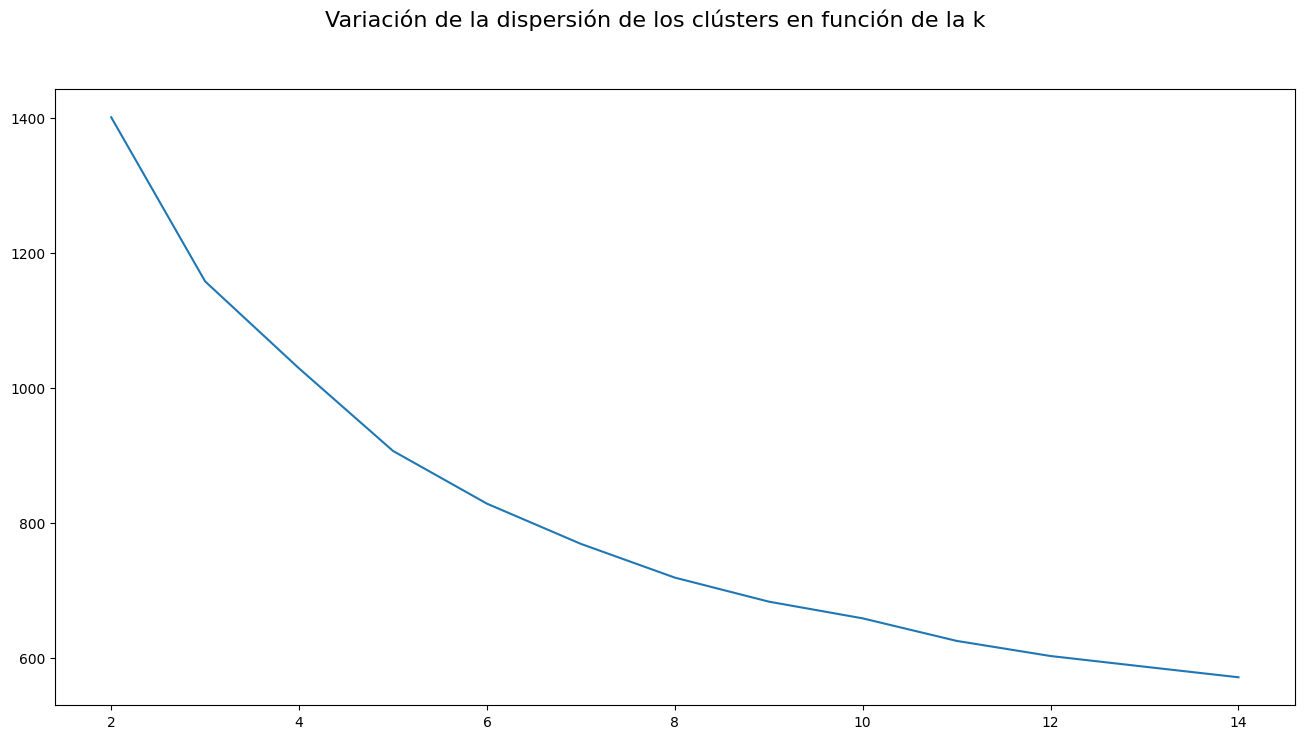

In [333]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

Vemos que hay varios puntos donde hay diferencia en la pendiente c 3, 5 y 10  Probamos con el de 5

## Segmentación de los clientes con la "k adecuada"

In [334]:
# Añadimos el clustering a la pipeline 

pipe = Pipeline(steps = [
    
    ("RobustScaler", RobustScaler(quantile_range = (0, 99.0))),
    ("Clustering", KMeans(n_clusters = 5, random_state = 175))
])

In [335]:
# Nos sirve para ver todos los pasos de la pipeline a la vez que fiteamos:
pipe.fit(df_features)

Pipeline(steps=[('RobustScaler', RobustScaler(quantile_range=(0, 99.0))),
                ('Clustering', KMeans(n_clusters=5, random_state=175))])

In [336]:
#X_processed = pipe[:2].transform(df_features)
X_processed = df_features.copy() 
#para poder analizar las variables sin escalado nos saltamos los ultimos pasos y procesamos los datos iniciales justo antes del escalado

In [337]:
labels = pipe.predict(df_features)
X_processed["cluster"] = labels

In [338]:
X_processed.shape

(3049, 16)

In [339]:
X_processed.head()

,total_sales,median_sales,max_sales,std_sales,mean_price,std_price,mean_revenue,median_revenue,Boston,New York,Philadelphia,mean_sales_year,std_sales_year,weekend,holiday,cluster
item,,,,,,,,,,,,,,,,
ACCESORIES_1_001,4093,0.0,13,2.262194,11.467211,0.735040,16.430898,0.0000,25.580259,61.935011,12.484730,682.166667,661.117362,33.276325,1.343758,2
ACCESORIES_1_002,5059,1.0,36,2.212540,5.276746,0.090298,9.746517,5.2801,17.355209,31.547737,51.097055,843.166667,299.731491,35.125519,1.087171,0
ACCESORIES_1_003,1435,0.0,16,1.232909,3.947629,0.127959,2.062859,0.0000,26.341463,50.940767,22.717770,239.166667,319.790192,37.909408,2.229965,0
ACCESORIES_1_004,39175,11.0,82,13.149637,5.979432,0.277099,85.914316,67.8832,24.747926,58.253989,16.998086,6529.166667,2471.921473,35.987237,1.375877,1
ACCESORIES_1_005,14621,4.0,42,5.211182,3.837511,0.222676,20.313211,16.3856,28.329116,51.166131,20.504753,2436.833333,693.242646,35.907257,1.162711,0


### Ficha de los productos

In [340]:
ficha_df = pd.DataFrame()
media_df = pd.DataFrame()

In [341]:
l_features

['total_sales',
 'median_sales',
 'max_sales',
 'std_sales',
 'mean_price',
 'std_price',
 'mean_revenue',
 'median_revenue',
 'Boston',
 'New York',
 'Philadelphia',
 'mean_sales_year',
 'std_sales_year',
 'weekend',
 'holiday']

In [342]:
for i, col in enumerate(l_features):
    resumen_data = X_processed[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = pd.concat([ficha_df, resumen_data])

In [343]:
for i, col in enumerate(l_features):
    resumen_data = X_processed.groupby("cluster")[col].mean()
    media_df[col + '_mean'] = resumen_data
media_df = media_df.T

In [344]:
media_df.style.background_gradient(cmap = 'Blues', axis = 1)

cluster,0,1,2,3,4
total_sales_mean,12036.024680,74207.055556,7909.457760,961385.500000,243285.068182
median_sales_mean,2.615174,19.864379,1.616896,294.000000,67.090909
max_sales_mean,44.634369,230.294118,28.587426,2540.000000,731.659091
std_sales_mean,5.232686,27.636084,3.610151,292.118393,83.743445
mean_price_mean,4.304589,3.251903,12.689372,1.771855,1.921290
std_price_mean,0.140709,0.150705,0.628375,0.116828,0.094913
mean_revenue_mean,15.915247,75.362499,34.745531,616.616621,170.400214
median_revenue_mean,9.539116,54.453272,18.795803,525.684000,129.272432
Boston_mean,26.384835,29.336771,28.836639,41.104414,30.827871
New York_mean,45.203923,42.851035,49.030388,41.526363,40.575561


In [345]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)


In [346]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

In [347]:
df_cluster =  X_processed[['cluster']].reset_index()
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3049 entries, 0 to 3048
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   item     3049 non-null   object
 1   cluster  3049 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 35.9+ KB


In [ ]:
df_cluster.to_csv((ruta+'product_cluster.csv'), index=False)